In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('display.float_format', '{:.2f}'.format)

from sklearn.model_selection import train_test_split as tts   # el alias es cosa mia

from sklearn.ensemble import RandomForestRegressor as rfr

from sklearn.ensemble import ExtraTreesRegressor

from sklearn.preprocessing import StandardScaler

pd.options.mode.copy_on_write = True

In [2]:
df = pd.read_csv("../NBA_csv/StatsAllTrain2.csv")

In [3]:
df.head()

,Player,Salario,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,DeMar DeRozan,27739975,AL,30,SAS,68,68,2316,557,1049,0.53,9,35,0.26,548,1014,0.54,0.54,381,451,0.84,44,331,375,380,70,20,164,180,1504
1,LaMarcus Aldridge,26000000,P,34,SAS,53,53,1754,391,793,0.49,61,157,0.39,330,636,0.52,0.53,158,191,0.83,103,289,392,129,36,87,74,128,1001
2,Rudy Gay,14000000,AP,33,SAS,67,5,1461,266,596,0.45,74,220,0.34,192,376,0.51,0.51,120,136,0.88,61,301,362,114,35,33,88,103,726
3,Patty Mills,12428571,BA,31,SAS,66,1,1485,258,598,0.43,154,403,0.38,104,195,0.53,0.56,97,112,0.87,22,86,108,118,53,6,54,105,767
4,Marco Belinelli,5846154,ES,33,SAS,57,0,883,123,314,0.39,67,178,0.38,56,136,0.41,0.50,48,58,0.83,7,92,99,69,12,1,19,45,361


In [4]:
#df['PER'] = (df['PTS'] + (df['AST'] + df['TRB'] + df['STL'] + df['BLK'] - df['TOV']) / df['G']) / (df['MP'] / 48)

# Mostrar el DataFrame con la nueva columna PER

In [5]:
df = df.dropna()

In [6]:
df.describe()

,Salario,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
count,2237.00,2237.00,2237.00,2237.00,2237.00,2237.00,2237.00,2237.00,2237.00,2237.00,2237.00,2237.00,2237.00,2237.00,2237.00,2237.00,2237.00,2237.00,2237.00,2237.00,2237.00,2237.00,2237.00,2237.00,2237.00,2237.00,2237.00
mean,8279469.71,26.13,48.32,23.34,1123.86,192.66,414.02,0.46,59.23,163.85,0.32,133.44,250.17,0.52,0.53,81.80,104.60,0.76,45.77,155.97,201.74,119.16,34.98,21.70,62.59,91.26,526.36
std,9991876.05,4.32,20.26,25.16,716.76,159.43,334.19,0.08,57.28,149.68,0.12,125.25,229.52,0.10,0.08,92.36,113.37,0.13,46.03,125.88,164.16,121.46,26.07,24.08,54.41,56.65,443.46
min,10492.00,19.00,1.00,0.00,4.00,0.00,2.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,1801769.00,23.00,36.00,1.00,493.00,66.00,147.00,0.41,11.00,35.00,0.29,38.00,73.00,0.47,0.49,19.00,27.00,0.70,15.00,61.00,81.00,32.00,14.00,6.00,21.00,46.00,173.00
50%,3889800.00,26.00,53.00,11.00,1080.00,153.00,331.00,0.45,44.00,126.00,0.34,94.00,181.00,0.52,0.53,50.00,68.00,0.78,32.00,131.00,166.00,80.00,31.00,14.00,48.00,89.00,415.00
75%,10843350.00,29.00,64.00,45.00,1712.00,280.00,601.00,0.49,93.00,256.00,0.39,195.00,358.00,0.58,0.57,108.00,140.00,0.84,60.00,221.00,282.00,163.00,51.00,29.00,88.00,129.00,754.00
max,51915615.00,43.00,83.00,83.00,2963.00,774.00,1564.00,0.78,337.00,843.00,1.00,724.00,1393.00,1.00,0.89,692.00,803.00,1.00,349.00,813.00,1019.00,763.00,138.00,196.00,312.00,286.00,2335.00


In [7]:
df = df[df["Salario"]>=953000]

In [8]:
#vamos a convertir las stadisticas a minutos para que sea todo mas equitativo
df['PTS'] = df['PTS'] / df['G']
df['2P'] = df['2P'] / df["G"]
df['2PA'] = df['2PA'] / df["G"]
df['3P'] = df['3P'] / df['G']
df['3PA'] = df['3PA'] / df['G']
df['FG'] = df['FG'] / df['G']
df['FGA'] = df['FGA'] / df['G']
df['FT'] = df['FT'] / df['G']
df['FTA'] = df['FTA'] / df['G']
df['ORB'] = df['ORB'] / df['G']
df['DRB'] = df['DRB'] / df['G']
df['TRB'] = df['TRB'] / df['G']
df['AST'] = df['AST'] / df['G']
df['STL'] = df['STL'] / df['G']
df['BLK'] = df['BLK'] / df['G']
df['TOV'] = df['TOV'] / df['G']
df['PF'] = df['PF'] / df['G']

In [9]:
df_numericas = df.select_dtypes(include=['number'])
#df_numericas.drop(columns = ["STL","PF","BLK","TRB","eFG%","3P%","FG%","2P%","ORB"], inplace= True)

df_numericas = df.drop(columns=["Player","STL","PF","BLK","TRB","eFG%","3P%","FG%","2P%","ORB","Pos","Tm","FT%"])

In [10]:
df_numericas

,Salario,Age,G,GS,MP,FG,FGA,3P,3PA,2P,2PA,FT,FTA,DRB,AST,TOV,PTS
0,27739975,30,68,68,2316,8.19,15.43,0.13,0.51,8.06,14.91,5.60,6.63,4.87,5.59,2.41,22.12
1,26000000,34,53,53,1754,7.38,14.96,1.15,2.96,6.23,12.00,2.98,3.60,5.45,2.43,1.40,18.89
2,14000000,33,67,5,1461,3.97,8.90,1.10,3.28,2.87,5.61,1.79,2.03,4.49,1.70,1.31,10.84
3,12428571,31,66,1,1485,3.91,9.06,2.33,6.11,1.58,2.95,1.47,1.70,1.30,1.79,0.82,11.62
4,5846154,33,57,0,883,2.16,5.51,1.18,3.12,0.98,2.39,0.84,1.02,1.61,1.21,0.33,6.33
5,5500000,24,63,53,1271,2.43,5.44,1.03,2.67,1.40,2.78,0.52,0.71,4.60,1.10,0.62,6.41
6,2875000,26,63,62,1579,3.84,9.22,2.35,6.05,1.49,3.17,1.19,1.43,1.81,1.71,0.90,11.22
7,2689920,20,3,1,48,1.67,5.33,1.00,2.67,0.67,2.67,1.00,1.33,3.00,2.00,0.67,5.33
8,2321735,23,66,58,1687,4.45,9.65,0.62,1.68,3.83,7.97,1.38,1.73,4.76,4.11,1.89,10.91
9,1950600,20,17,1,301,3.12,5.24,0.76,1.29,2.35,3.94,2.06,2.59,2.76,0.88,0.76,9.06


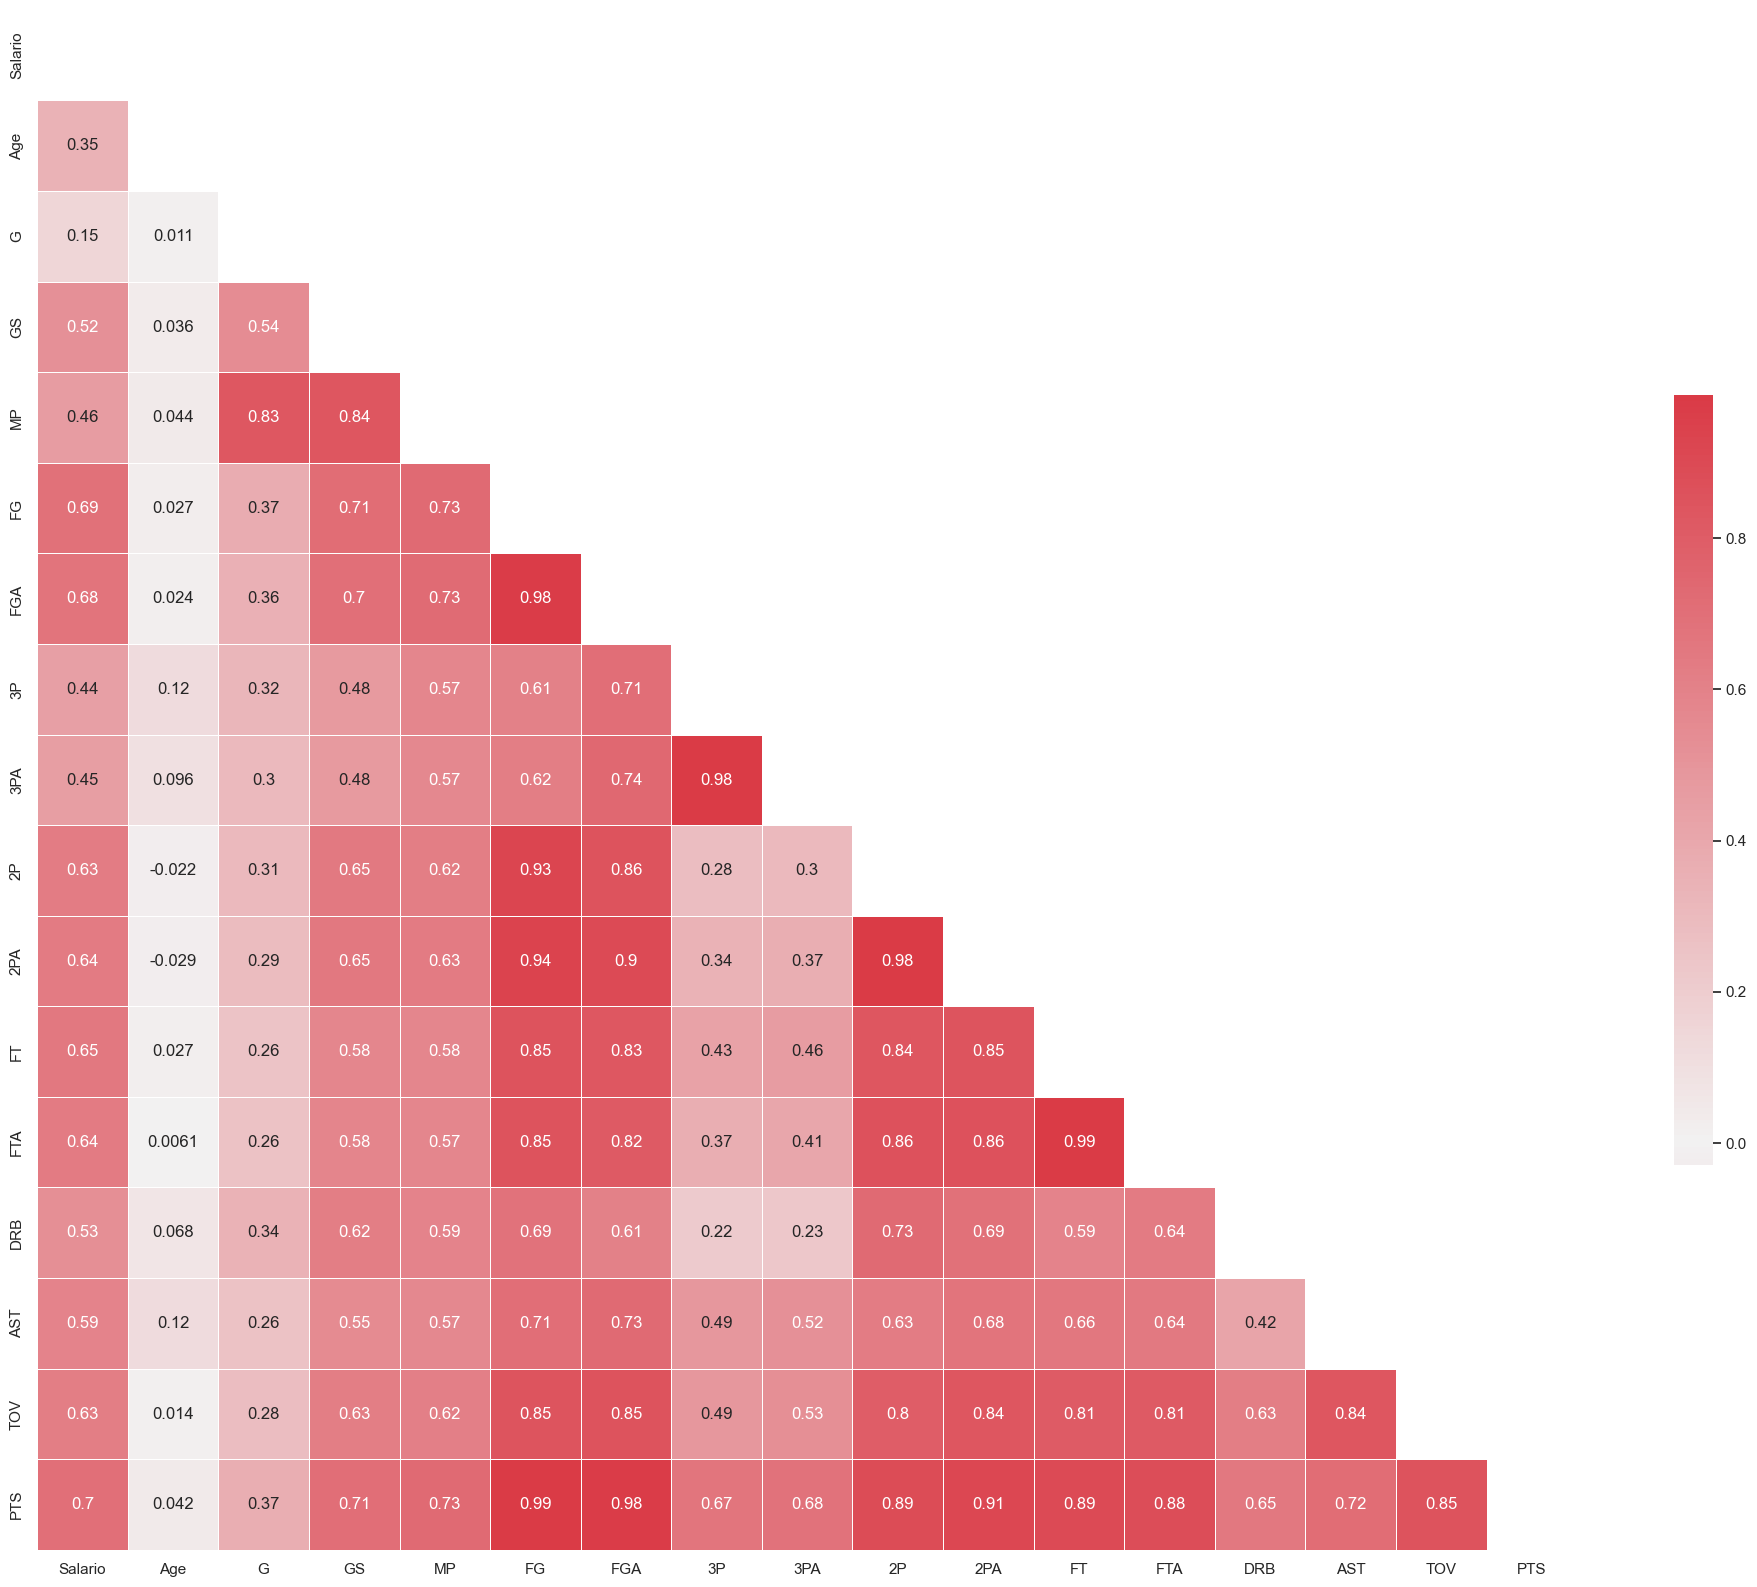

In [11]:
#tiramos un heatmap para ver la colinialidad de las Variables.

plt.figure(figsize=(25, 20))

sns.set(style='white')

mask=np.triu(np.ones_like(df_numericas.corr(), dtype=bool))

cmap=sns.diverging_palette(0, 10, as_cmap=True)


sns.heatmap(df_numericas.corr(),
           mask=mask,
           cmap=cmap,
           center=0,
           square=True,
           annot=True,
           linewidths=0.5,
           cbar_kws={'shrink': 0.5});

In [12]:
X = df_numericas.drop(columns="Salario")
 
y = df_numericas.Salario

X.head()

,Age,G,GS,MP,FG,FGA,3P,3PA,2P,2PA,FT,FTA,DRB,AST,TOV,PTS
0,30,68,68,2316,8.19,15.43,0.13,0.51,8.06,14.91,5.60,6.63,4.87,5.59,2.41,22.12
1,34,53,53,1754,7.38,14.96,1.15,2.96,6.23,12.00,2.98,3.60,5.45,2.43,1.40,18.89
2,33,67,5,1461,3.97,8.90,1.10,3.28,2.87,5.61,1.79,2.03,4.49,1.70,1.31,10.84
3,31,66,1,1485,3.91,9.06,2.33,6.11,1.58,2.95,1.47,1.70,1.30,1.79,0.82,11.62
4,33,57,0,883,2.16,5.51,1.18,3.12,0.98,2.39,0.84,1.02,1.61,1.21,0.33,6.33


In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [14]:
X_tr, X_ts, y_train, y_test = tts(X, y,
                                       test_size=0.2,
                                       random_state=42
                                      )

X_tr.shape, X_ts.shape, y_train.shape, y_test.shape

((1567, 16), (392, 16), (1567,), (392,))

In [15]:
X_train = pd.DataFrame(scaler.fit_transform(X_tr), columns=X_tr.columns)

X_test = pd.DataFrame(scaler.fit_transform(X_ts), columns=X_ts.columns)

In [16]:
from sklearn.model_selection import GridSearchCV, cross_val_score

In [17]:
X_train.shape

(1567, 16)

In [18]:
exr  = ExtraTreesRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                    random_state=42)

# Entrenar el modelo final en el conjunto de entrenamiento completo
exr.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = exr.predict(X_test)

# Evaluar el rendimiento del modelo en el conjunto de prueba
mse_test = mean_squared_error(y_test, y_pred)
rmse= np.sqrt(mse_test)

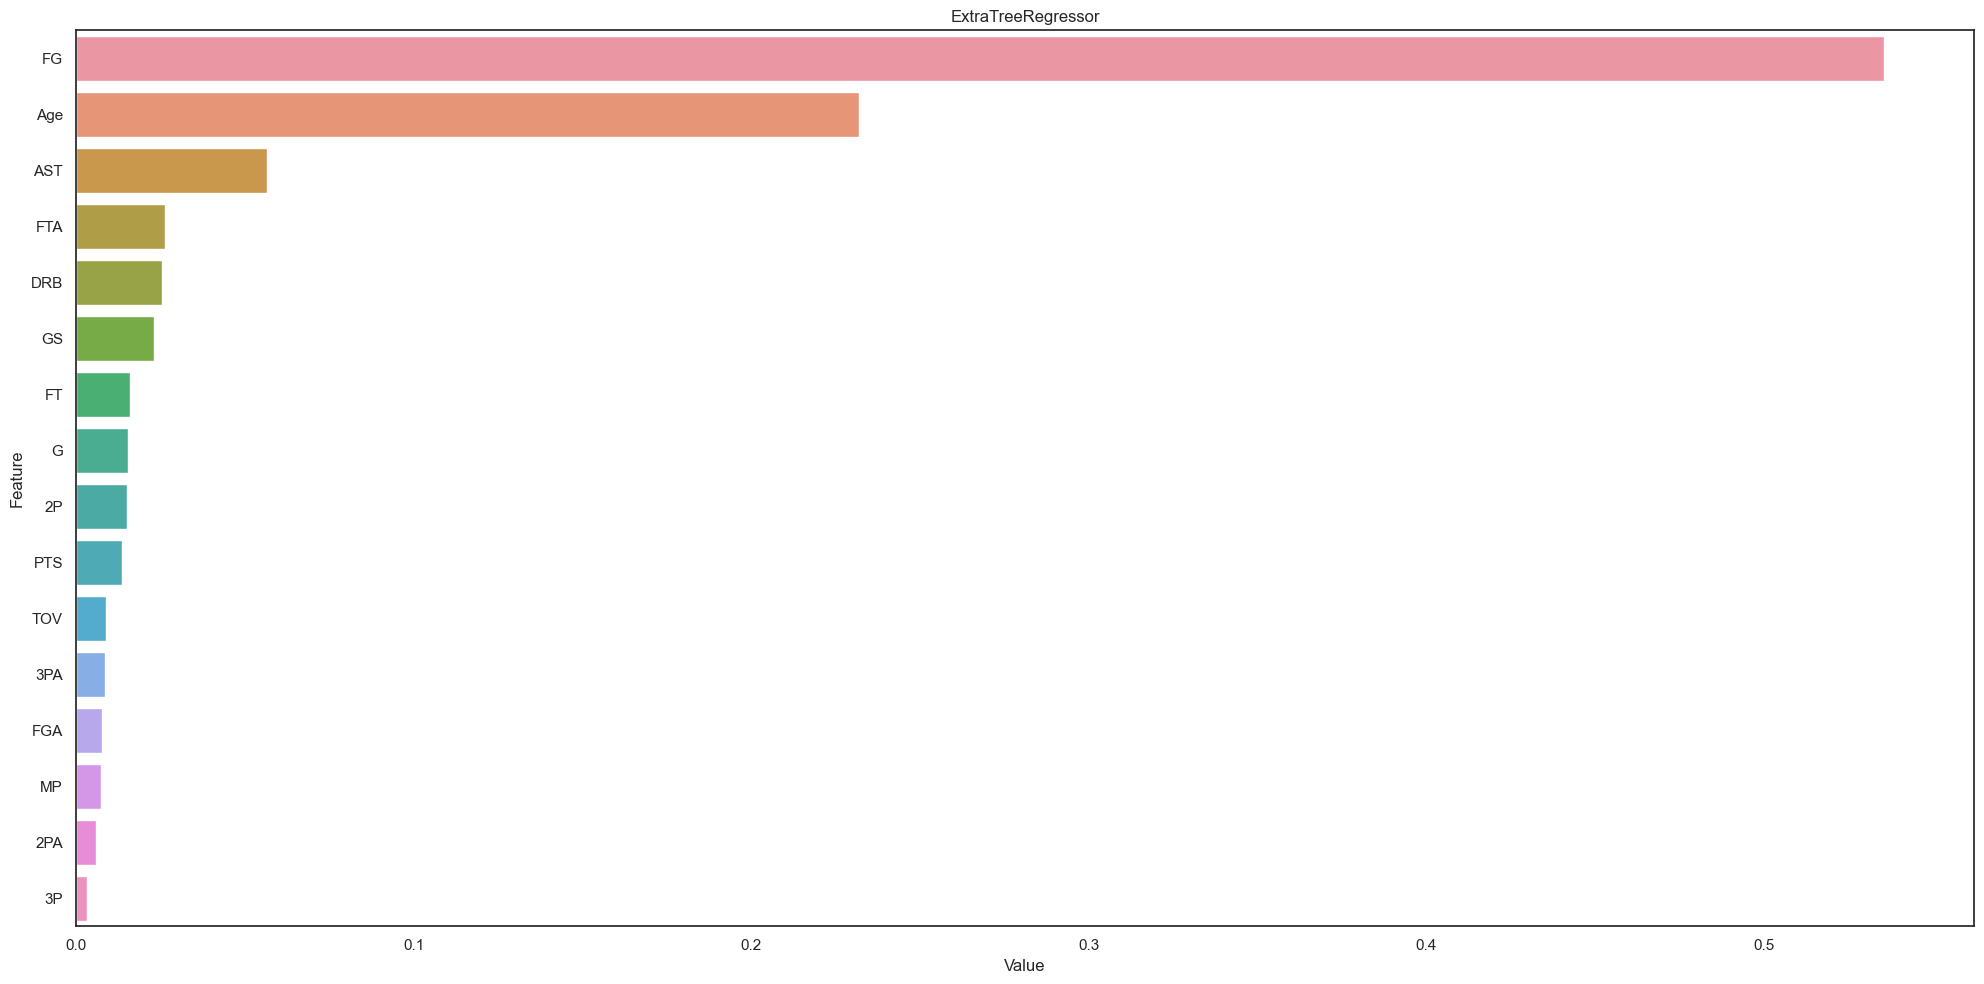

In [19]:
feature_imp = pd.DataFrame(sorted(zip(exr[0].feature_importances_,X_train.columns)),
                           columns=['Value','Feature'])
plt.figure(figsize=(20, 10)),
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)),
plt.title('ExtraTreeRegressor')
plt.tight_layout()
plt.show()

In [20]:
rmse

4829287.747432122

In [21]:
stats24_1 = pd.read_csv("../NBA_csv/stats_salary.csv")
salario_real = stats24_1.Salario

In [22]:
stats24 = stats24_1.drop(columns=["PF","eFG%","3P%","FG%","2P%","FT%","ORB"])

In [23]:
stats24.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,3P,3PA,2P,2PA,FT,FTA,DRB,TRB,AST,STL,BLK,TOV,PTS,Salario
0,Precious Achiuwa,P,24,TOT,56,17,1276,195,391,23,85,172,306,55,89,223,373,78,38,52,63,468,4379527
1,Bam Adebayo,P,26,MIA,53,53,1835,403,793,1,14,402,779,250,325,429,546,214,57,51,130,1057,32600060
2,Ochai Agbaji,ES,23,TOT,63,14,1208,132,323,56,177,76,146,24,32,109,155,57,32,33,44,344,4114200
3,Santi Aldama,AP,23,MEM,52,26,1334,210,485,89,255,121,230,42,69,228,290,115,34,41,63,551,2194200
4,Grayson Allen,ES,28,PHO,58,58,1949,250,505,154,328,96,177,100,113,191,227,179,50,37,75,754,8500000


In [24]:
#stats24['PER'] = (stats24['PTS'] + (stats24['AST'] + stats24['TRB'] + stats24['STL'] + stats24['BLK'] - stats24['TOV']) / stats24['G']) / (stats24['MP'] / 48)

In [25]:
stats24.drop(columns = ["TRB","BLK","STL"], inplace = True)

In [26]:
stats24.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,3P,3PA,2P,2PA,FT,FTA,DRB,AST,TOV,PTS,Salario
0,Precious Achiuwa,P,24,TOT,56,17,1276,195,391,23,85,172,306,55,89,223,78,63,468,4379527
1,Bam Adebayo,P,26,MIA,53,53,1835,403,793,1,14,402,779,250,325,429,214,130,1057,32600060
2,Ochai Agbaji,ES,23,TOT,63,14,1208,132,323,56,177,76,146,24,32,109,57,44,344,4114200
3,Santi Aldama,AP,23,MEM,52,26,1334,210,485,89,255,121,230,42,69,228,115,63,551,2194200
4,Grayson Allen,ES,28,PHO,58,58,1949,250,505,154,328,96,177,100,113,191,179,75,754,8500000


In [27]:
stats24['PTS'] = stats24['PTS'] / stats24['G']
stats24['2P'] = stats24['2P'] / stats24["G"]
stats24['2PA'] = stats24['2PA'] / stats24["G"]
stats24['3P'] = stats24['3P'] / stats24['G']
stats24['3PA'] = stats24['3PA'] / stats24['G']
stats24['FG'] = stats24['FG'] / stats24['G']
stats24['FGA'] = stats24['FGA'] / stats24['G']
stats24['FT'] = stats24['FT'] / stats24['G']
stats24['FTA'] = stats24['FTA'] / stats24['G']
stats24['DRB'] = stats24['DRB'] / stats24['G']
stats24['AST'] = stats24['AST'] / stats24['G']
stats24['TOV'] = stats24['TOV'] / stats24['G']

In [28]:
stats24_param = stats24.copy()
stats24_param.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,3P,3PA,2P,2PA,FT,FTA,DRB,AST,TOV,PTS,Salario
0,Precious Achiuwa,P,24,TOT,56,17,1276,3.48,6.98,0.41,1.52,3.07,5.46,0.98,1.59,3.98,1.39,1.12,8.36,4379527
1,Bam Adebayo,P,26,MIA,53,53,1835,7.60,14.96,0.02,0.26,7.58,14.70,4.72,6.13,8.09,4.04,2.45,19.94,32600060
2,Ochai Agbaji,ES,23,TOT,63,14,1208,2.10,5.13,0.89,2.81,1.21,2.32,0.38,0.51,1.73,0.90,0.70,5.46,4114200
3,Santi Aldama,AP,23,MEM,52,26,1334,4.04,9.33,1.71,4.90,2.33,4.42,0.81,1.33,4.38,2.21,1.21,10.60,2194200
4,Grayson Allen,ES,28,PHO,58,58,1949,4.31,8.71,2.66,5.66,1.66,3.05,1.72,1.95,3.29,3.09,1.29,13.00,8500000


In [29]:
stats24.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,3P,3PA,2P,2PA,FT,FTA,DRB,AST,TOV,PTS,Salario
0,Precious Achiuwa,P,24,TOT,56,17,1276,3.48,6.98,0.41,1.52,3.07,5.46,0.98,1.59,3.98,1.39,1.12,8.36,4379527
1,Bam Adebayo,P,26,MIA,53,53,1835,7.60,14.96,0.02,0.26,7.58,14.70,4.72,6.13,8.09,4.04,2.45,19.94,32600060
2,Ochai Agbaji,ES,23,TOT,63,14,1208,2.10,5.13,0.89,2.81,1.21,2.32,0.38,0.51,1.73,0.90,0.70,5.46,4114200
3,Santi Aldama,AP,23,MEM,52,26,1334,4.04,9.33,1.71,4.90,2.33,4.42,0.81,1.33,4.38,2.21,1.21,10.60,2194200
4,Grayson Allen,ES,28,PHO,58,58,1949,4.31,8.71,2.66,5.66,1.66,3.05,1.72,1.95,3.29,3.09,1.29,13.00,8500000


In [30]:
#stats24_X = stats24_number.drop(["Salario", "FG", "FGA","FT","TRB","2P","2PA","FT","FTA","TOV"], axis = 1)

In [31]:
stats24["Age"]=(stats24["Age"]-np.mean(stats24["Age"]))/np.std(stats24["Age"])
stats24["G"]=(stats24["G"]-np.mean(stats24["G"]))/np.std(stats24["G"])
stats24["GS"]=(stats24["GS"]-np.mean(stats24["GS"]))/np.std(stats24["GS"])
stats24["MP"]=(stats24["MP"]-np.mean(stats24["MP"]))/np.std(stats24["MP"])
stats24["FG"]=(stats24["FG"]-np.mean(stats24["FG"]))/np.std(stats24["FG"])
stats24["FGA"]=(stats24["FGA"]-np.mean(stats24["FGA"]))/np.std(stats24["FGA"])
stats24["3P"]=(stats24["3P"]-np.mean(stats24["3P"]))/np.std(stats24["3P"])
stats24["3PA"]=(stats24["3PA"]-np.mean(stats24["3PA"]))/np.std(stats24["3PA"])
stats24["2P"]=(stats24["2P"]-np.mean(stats24["2P"]))/np.std(stats24["2P"])
stats24["2PA"]=(stats24["2PA"]-np.mean(stats24["2PA"]))/np.std(stats24["2PA"])
stats24["FT"]=(stats24["FT"]-np.mean(stats24["FT"]))/np.std(stats24["FT"])
stats24["FTA"]=(stats24["FTA"]-np.mean(stats24["FTA"]))/np.std(stats24["FTA"])
#stats24["FT%"]=(stats24["FT%"]-np.mean(stats24["FT%"]))/np.std(stats24["FT%"])
stats24["DRB"]=(stats24["DRB"]-np.mean(stats24["DRB"]))/np.std(stats24["DRB"])
stats24["AST"]=(stats24["AST"]-np.mean(stats24["AST"]))/np.std(stats24["AST"])
stats24["TOV"]=(stats24["TOV"]-np.mean(stats24["TOV"]))/np.std(stats24["TOV"])
stats24["PTS"]=(stats24["PTS"]-np.mean(stats24["PTS"]))/np.std(stats24["PTS"])

In [32]:
stats24_salario = stats24.Salario

stats = stats24.drop(columns=["Salario"])

# Elimina la columna 'Tm' y almacénala en otra variable
tm_column = stats.pop('Tm')

# Inserta la columna 'Tm' en la segunda posición del DataFrame
stats.insert(1, 'Tm', tm_column)

In [33]:
stats.isna().sum()
stats["Pos"].fillna("BA")

0       P
1       P
2      ES
3      AP
4      ES
5       P
6      BA
7      AP
8      BA
9      AL
10     BA
11     AL
12      P
13      P
14     AL
15     BA
16      P
17     AP
18     ES
19     BA
20     AP
21     AP
22     ES
23     ES
24      P
25     AL
26     AP
27     AP
28     ES
29     ES
30     AL
31     BA
32     AL
33      P
34     ES
35      P
36     BA
37     AP
38      P
39     BA
40     AP
41     ES
42     BA
43     BA
44     ES
45     AL
46     AL
47     AL
48     BA
49     BA
50     BA
51     AL
52     ES
53     AL
54     AP
55      P
56     BA
57      P
58     ES
59     AL
60     ES
61     AP
62     AP
63      P
64     BA
65      P
66     ES
67     ES
68     AL
69     ES
70     AL
71     ES
72     AP
73     AL
74     AP
75      P
76     BA
77     AL
78     AL
79     BA
80     AL
81     AP
82     BA
83     BA
84     ES
85     BA
86     BA
87      P
88     ES
89     ES
90     AL
91     AP
92     ES
93     ES
94     AP
95     BA
96     ES
97     AL
98     ES
99      P


In [34]:
#error

In [35]:
# Realizar predicciones en el conjunto de prueba
y_pred = exr.predict(stats.iloc[:,3:])
y_pred

array([ 4978289.1842254 , 26769982.8027829 ,  3219585.96093219,
        5833777.69605811, 12949591.36850541, 21385632.76814385,
        4132244.29628405,  7865063.45667527,  6378361.95046839,
       17464444.91850115,  4132962.59509403, 11622233.29270128,
       23734839.09372789, 10659488.079119  ,  2672137.50701144,
       12789282.53217307,  3293664.35140482,  9793126.03836158,
       25184870.78481531,  3390227.87142414,  3164617.84621857,
       14839461.0343833 ,  9724045.30708107, 14288128.04292381,
        3022717.17963294,  4951705.82836754,  8001604.77595082,
        2087105.04997094, 32021798.00806319, 10127376.24705056,
        2921607.70053468,  8403396.45907813, 11060509.79369608,
        3670300.77277877,  2667705.72494881,  8320262.10447583,
        3544529.303978  ,  3739798.00231022,  2424600.88854672,
       31762777.81899728,  6747486.72303311,  2675241.82790451,
        3879807.31844067,  4601495.07044216,  3268075.23117085,
       24176932.06687322, 18889659.93025

In [36]:
stats["Predict_salario"] = pd.DataFrame(y_pred)
stats["Predict_salario"]

0      4978289.18
1     26769982.80
2      3219585.96
3      5833777.70
4     12949591.37
5     21385632.77
6      4132244.30
7      7865063.46
8      6378361.95
9     17464444.92
10     4132962.60
11    11622233.29
12    23734839.09
13    10659488.08
14     2672137.51
15    12789282.53
16     3293664.35
17     9793126.04
18    25184870.78
19     3390227.87
20     3164617.85
21    14839461.03
22     9724045.31
23    14288128.04
24     3022717.18
25     4951705.83
26     8001604.78
27     2087105.05
28    32021798.01
29    10127376.25
30     2921607.70
31     8403396.46
32    11060509.79
33     3670300.77
34     2667705.72
35     8320262.10
36     3544529.30
37     3739798.00
38     2424600.89
39    31762777.82
40     6747486.72
41     2675241.83
42     3879807.32
43     4601495.07
44     3268075.23
45    24176932.07
46    18889659.93
47     3297785.78
48     4669352.03
49    24248801.45
50     3732092.04
51    14208252.96
52    12661173.78
53    29503769.32
54     2538566.07
55     334

In [37]:
stats["Real_salario"] = stats24_salario

In [38]:
stats

,Player,Tm,Pos,Age,G,GS,MP,FG,FGA,3P,3PA,2P,2PA,FT,FTA,DRB,AST,TOV,PTS,Predict_salario,Real_salario
0,Precious Achiuwa,TOT,P,-0.45,0.79,-0.13,0.49,0.04,-0.05,-0.68,-0.58,0.36,0.31,-0.27,-0.09,0.73,-0.41,0.08,-0.12,4978289.18,4379527
1,Bam Adebayo,MIA,P,0.01,0.63,1.50,1.34,1.71,1.52,-1.11,-1.12,2.66,2.90,2.34,2.56,3.04,0.97,1.75,1.57,26769982.80,32600060
2,Ochai Agbaji,TOT,ES,-0.67,1.17,-0.27,0.39,-0.52,-0.41,-0.15,-0.02,-0.58,-0.57,-0.69,-0.73,-0.54,-0.66,-0.45,-0.54,3219585.96,4114200
3,Santi Aldama,MEM,AP,-0.67,0.57,0.28,0.58,0.27,0.41,0.75,0.89,-0.01,0.02,-0.39,-0.25,0.96,0.02,0.19,0.21,5833777.70,2194200
4,Grayson Allen,PHO,ES,0.46,0.90,1.72,1.52,0.38,0.29,1.79,1.21,-0.36,-0.37,0.25,0.11,0.34,0.48,0.30,0.56,12949591.37,8500000
5,Jarrett Allen,CLE,P,-0.22,0.90,1.72,1.35,1.29,0.64,-1.13,-1.20,2.15,1.69,1.19,1.42,2.62,0.30,0.77,1.03,21385632.77,20000000
6,Jose Alvarado,NOP,BA,-0.22,0.04,-0.90,-0.35,-0.35,-0.21,0.23,0.29,-0.54,-0.49,-0.48,-0.44,-0.50,-0.06,-0.34,-0.32,4132244.30,1836096
7,Kyle Anderson,MIN,AP,0.91,1.11,-0.63,0.65,-0.38,-0.39,-0.99,-0.98,-0.02,0.07,-0.09,0.00,0.05,0.99,0.23,-0.42,7865063.46,9219512
8,Cole Anthony,ORL,BA,-0.67,1.17,-0.90,0.75,0.28,0.43,0.01,0.18,0.34,0.50,0.79,0.74,0.28,0.47,0.79,0.36,6378361.95,5539771
9,OG Anunoby,TOT,AL,0.01,-0.02,0.96,0.68,0.98,0.87,1.18,1.16,0.69,0.49,0.15,0.17,0.30,0.05,0.57,0.89,17464444.92,18642857


In [39]:
dupli_stats = stats.copy()

dupli_stats.head()

,Player,Tm,Pos,Age,G,GS,MP,FG,FGA,3P,3PA,2P,2PA,FT,FTA,DRB,AST,TOV,PTS,Predict_salario,Real_salario
0,Precious Achiuwa,TOT,P,-0.45,0.79,-0.13,0.49,0.04,-0.05,-0.68,-0.58,0.36,0.31,-0.27,-0.09,0.73,-0.41,0.08,-0.12,4978289.18,4379527
1,Bam Adebayo,MIA,P,0.01,0.63,1.50,1.34,1.71,1.52,-1.11,-1.12,2.66,2.90,2.34,2.56,3.04,0.97,1.75,1.57,26769982.80,32600060
2,Ochai Agbaji,TOT,ES,-0.67,1.17,-0.27,0.39,-0.52,-0.41,-0.15,-0.02,-0.58,-0.57,-0.69,-0.73,-0.54,-0.66,-0.45,-0.54,3219585.96,4114200
3,Santi Aldama,MEM,AP,-0.67,0.57,0.28,0.58,0.27,0.41,0.75,0.89,-0.01,0.02,-0.39,-0.25,0.96,0.02,0.19,0.21,5833777.70,2194200
4,Grayson Allen,PHO,ES,0.46,0.90,1.72,1.52,0.38,0.29,1.79,1.21,-0.36,-0.37,0.25,0.11,0.34,0.48,0.30,0.56,12949591.37,8500000


In [40]:
# Lista de columnas a desnormalizar
columns_to_desnormalize = ["Age", "G", "GS", "MP", "FG", "FGA", "3P", "3PA", "2P", "2PA",
                            "FT", "FTA", "DRB", "AST", "TOV", "PTS"]

# Desnormalizar cada columna
for column in columns_to_desnormalize:
    stats[column] = (stats[column] * np.std(stats24_param[column])) + np.mean(stats24_param[column])

In [41]:
stats.head() # (el valor real - el predicho) / el real 

,Player,Tm,Pos,Age,G,GS,MP,FG,FGA,3P,3PA,2P,2PA,FT,FTA,DRB,AST,TOV,PTS,Predict_salario,Real_salario
0,Precious Achiuwa,TOT,P,24.00,56.00,17.00,1276.00,3.48,6.98,0.41,1.52,3.07,5.46,0.98,1.59,3.98,1.39,1.12,8.36,4978289.18,4379527
1,Bam Adebayo,MIA,P,26.00,53.00,53.00,1835.00,7.60,14.96,0.02,0.26,7.58,14.70,4.72,6.13,8.09,4.04,2.45,19.94,26769982.80,32600060
2,Ochai Agbaji,TOT,ES,23.00,63.00,14.00,1208.00,2.10,5.13,0.89,2.81,1.21,2.32,0.38,0.51,1.73,0.90,0.70,5.46,3219585.96,4114200
3,Santi Aldama,MEM,AP,23.00,52.00,26.00,1334.00,4.04,9.33,1.71,4.90,2.33,4.42,0.81,1.33,4.38,2.21,1.21,10.60,5833777.70,2194200
4,Grayson Allen,PHO,ES,28.00,58.00,58.00,1949.00,4.31,8.71,2.66,5.66,1.66,3.05,1.72,1.95,3.29,3.09,1.29,13.00,12949591.37,8500000


In [42]:
stats["Diferencia_%"] = ((stats["Real_salario"] - stats["Predict_salario"] ) / stats["Real_salario"]) *100

In [43]:
stats = stats.fillna(stats.Predict_salario.median())

In [44]:
stats.Age = stats.Age.astype(int)
stats.G = stats.G.astype(int)
stats.GS= stats.GS.astype(int)
stats.MP= stats.MP.astype(int)
stats.FG= stats.FG.astype(int)
stats.FGA= stats.FGA.astype(int)
stats["3P"]= stats["3P"].astype(int)
stats["3PA"]= stats["3PA"].astype(int)
stats["2P"]= stats["2P"].astype(int)
stats["2PA"]= stats["2PA"].astype(int)
stats.FT= stats.FT.astype(int)
stats.FTA= stats.FTA.astype(int)
stats.DRB= stats.DRB.astype(int)
stats.AST= stats.AST.astype(int)
stats.TOV= stats.TOV.astype(int)
stats.PTS= stats.PTS.astype(int)
stats.Predict_salario= stats.Predict_salario.astype(int)

In [45]:
stats["Diferencia_%"] = stats["Diferencia_%"].astype(str)

stats["Diferencia_%"]=stats["Diferencia_%"].str.replace(".",",")

In [46]:
nba_teams = {
    'ATL': "https://cdn.ssref.net/req/202312151/tlogo/bbr/ATL-2024.png",
    'BOS': "https://cdn.ssref.net/req/202312151/tlogo/bbr/BOS-2024.png",
    'BRK': "https://cdn.ssref.net/req/202312151/tlogo/bbr/BRK-2024.png",
    'CHO': "https://cdn.ssref.net/req/202312151/tlogo/bbr/CHO-2024.png",
    'CHI': "https://cdn.ssref.net/req/202312151/tlogo/bbr/CHI-2024.png",
    'CLE': "https://cdn.ssref.net/req/202312151/tlogo/bbr/CLE-2024.png",
    'DAL': "https://cdn.ssref.net/req/202312151/tlogo/bbr/DAL-2024.png",
    'DEN': "https://cdn.ssref.net/req/202312151/tlogo/bbr/DEN-2024.png",
    'DET': "https://cdn.ssref.net/req/202312151/tlogo/bbr/DET-2024.png",
    'GSW': "https://cdn.ssref.net/req/202312151/tlogo/bbr/GSW-2024.png",
    'HOU': "https://cdn.ssref.net/req/202312151/tlogo/bbr/HOU-2024.png",
    'IND': "https://cdn.ssref.net/req/202312151/tlogo/bbr/IND-2024.png",
    'LAC': "https://cdn.ssref.net/req/202312151/tlogo/bbr/LAC-2024.png",
    'LAL': "https://cdn.ssref.net/req/202312151/tlogo/bbr/LAL-2024.png",
    'MEM': "https://cdn.ssref.net/req/202312151/tlogo/bbr/MEM-2024.png",
    'MIA': "https://cdn.ssref.net/req/202312151/tlogo/bbr/MIA-2024.png",
    'MIL': "https://cdn.ssref.net/req/202312151/tlogo/bbr/MIL-2024.png",
    'MIN': "https://cdn.ssref.net/req/202312151/tlogo/bbr/MIN-2024.png",
    'NOP': "https://cdn.ssref.net/req/202312151/tlogo/bbr/NOP-2024.png",
    'NYK': "https://cdn.ssref.net/req/202312151/tlogo/bbr/NYK-2024.png",
    'OKC': "https://cdn.ssref.net/req/202312151/tlogo/bbr/OKC-2024.png",
    'ORL': "https://cdn.ssref.net/req/202312151/tlogo/bbr/ORL-2024.png",
    'PHI': "https://cdn.ssref.net/req/202312151/tlogo/bbr/PHI-2024.png",
    'PHO': "https://cdn.ssref.net/req/202312151/tlogo/bbr/PHO-2024.png",
    'POR': "https://cdn.ssref.net/req/202312151/tlogo/bbr/POR-2024.png",
    'SAC': "https://cdn.ssref.net/req/202312151/tlogo/bbr/SAC-2024.png",
    'SAS': "https://cdn.ssref.net/req/202312151/tlogo/bbr/SAS-2024.png",
    'TOR': "https://cdn.ssref.net/req/202312151/tlogo/bbr/TOR-2024.png",
    'UTA': "https://cdn.ssref.net/req/202312151/tlogo/bbr/UTA-2024.png",
    'WAS': "https://cdn.ssref.net/req/202312151/tlogo/bbr/WAS-2024.png"
}


In [47]:
stats['Image_URL'] = stats['Tm'].map(nba_teams)

In [48]:
nba_names = {
    'ATL': "Atlanta Hawks",
    'BOS': "Boston Celtics",
    'BRK': "Brooklyn Nets",
    'CHO': "Charlotte Hornets",
    'CHI': "Chicago Bulls",
    'CLE': "Cleveland Cavaliers",
    'DAL': "Dallas Mavericks",
    'DEN': "Denver Nuggets",
    'DET': "Detroit Pistons",
    'GSW': "Golden State Warriors",
    'HOU': "Houston Rockets",
    'IND': "Indiana Pacers",
    'LAC': "Los Angeles Clippers",
    'LAL': "Los Angeles Lakers",
    'MEM': "Memphis Grizzlies",
    'MIA': "Miami Heat",
    'MIL': "Milwaukee Bucks",
    'MIN': "Minnesota Timberwolves",
    'NOP': "New Orleans Pelicans",
    'NYK': "New York Knicks",
    'OKC': "Oklahoma City Thunder",
    'ORL': "Orlando Magic",
    'PHI': "Philadelphia 76ers",
    'PHO': "Phoenix Suns",
    'POR': "Portland Trail Blazers",
    'SAC': "Sacramento Kings",
    'SAS': "San Antonio Spurs",
    'TOR': "Toronto Raptors",
    'UTA': "Utah Jazz",
    'WAS': "Washington Wizards"
}

In [49]:
stats["Tm"] = stats["Tm"].replace(nba_names)

In [50]:
stats.to_csv("statsOficial.csv", index = False)